This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

In [1]:
import argparse
import pathlib

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import tifffile
import torch
import tqdm
from cellpose import models
from csbdeep.utils import normalize
from PIL import Image
from stardist.plot import render_label

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(in_notebook)

True


In [2]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    parser.add_argument(
        "--clip_limit",
        type=float,
        help="Clip limit for the adaptive histogram equalization",
    )
    parser.add_argument(
        "--diameter",
        type=bool,
        help="diameter of the nuclei to segment",
    )

    args = parser.parse_args()
    clip_limit = args.clip_limit
    input_dir = pathlib.Path(args.input_dir).resolve(strict=True)
    diameter = args.diameter

else:
    input_dir = pathlib.Path(
        "../../2.cellprofiler_ic_processing/illum_directory/test_data/endpoint"
    ).resolve(strict=True)
    clip_limit = 0.6


list_of_input_dirs = list(input_dir.glob("*"))
list_of_input_dirs = [x for x in list_of_input_dirs if x.is_dir()]
print(list_of_input_dirs)

figures_dir = pathlib.Path("../figures").resolve()
figures_dir.mkdir(exist_ok=True, parents=True)

[PosixPath('/home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/test_data/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_C-03_F0001'), PosixPath('/home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/test_data/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_C-02_F0001'), PosixPath('/home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/test_data/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_C-04_F0001'), PosixPath('/home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/test_data/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_E-11_F0004'), PosixPath('/home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/test_data/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_E-11_F0001'), PosixPath('/home/lippincm/4TB_A/live_cell_timelapse_ap

In [3]:
# set up memory profiler for GPU
device = torch.device("cuda:0")
free_before, total_before = torch.cuda.mem_get_info(device)
starting_level_GPU_RAM = (total_before - free_before) / 1024**2
print("Starting level of GPU RAM available (MB): ", starting_level_GPU_RAM)

Starting level of GPU RAM available (MB):  1782.75


## Set up images, paths and functions

In [4]:
unique_masks_dict = {
    "diameter": [],
    "unique_masks": [],
    "image_dir": [],
}


for input_dir in tqdm.tqdm(list_of_input_dirs):
    if "2ch" not in str(input_dir):
        image_extensions = {".tif", ".tiff"}
        files = sorted(input_dir.glob("*"))
        files = [str(x) for x in files if x.suffix in image_extensions]
        image_dict = {
            "nuclei_file_paths": [],
            "nuclei": [],
            "cytoplasm1": [],
            "cytoplasm2": [],
            "cytoplasm3": [],
        }

        # split files by channel
        for file in files:
            if "C01" in file.split("/")[-1]:
                image_dict["nuclei_file_paths"].append(file)
                image_dict["nuclei"].append(tifffile.imread(file).astype(np.float32))
            elif "C02" in file.split("/")[-1]:
                image_dict["cytoplasm1"].append(
                    tifffile.imread(file).astype(np.float32)
                )
            elif "C03" in file.split("/")[-1]:
                image_dict["cytoplasm2"].append(
                    tifffile.imread(file).astype(np.float32)
                )
            elif "C04" in file.split("/")[-1]:
                image_dict["cytoplasm3"].append(
                    tifffile.imread(file).astype(np.float32)
                )

        cytoplasm_image_list = [
            np.max(
                np.array(
                    [
                        cytoplasm1,
                        cytoplasm2,
                        cytoplasm3,
                    ]
                ),
                axis=0,
            )
            for cytoplasm1, cytoplasm2, cytoplasm3 in zip(
                image_dict["cytoplasm1"],
                image_dict["cytoplasm2"],
                image_dict["cytoplasm3"],
            )
        ]
        nuclei_image_list = [np.array(nuclei) for nuclei in image_dict["nuclei"]]
    elif "2ch" in str(input_dir):
        image_extensions = {".tif", ".tiff"}
        files = sorted(input_dir.glob("*"))
        files = [str(x) for x in files if x.suffix in image_extensions]
        image_dict = {
            "nuclei_file_paths": [],
            "nuclei": [],
            "cytoplasm1": [],
        }
        # split files by channel
        for file in files:
            if "C01" in file.split("/")[-1]:
                image_dict["nuclei_file_paths"].append(file)
                image_dict["nuclei"].append(tifffile.imread(file).astype(np.float32))
            elif "C05" in file.split("/")[-1]:
                image_dict["cytoplasm1"].append(
                    tifffile.imread(file).astype(np.float32)
                )

        cytoplasm_image_list = [
            np.array(cytoplasm) for cytoplasm in image_dict["cytoplasm1"]
        ]
        nuclei_image_list = [np.array(nuclei) for nuclei in image_dict["nuclei"]]

    cyto = np.array(cytoplasm_image_list).astype(np.int16)
    nuclei = np.array(nuclei_image_list).astype(np.int16)

    cyto = cyto[0, :, :]
    nuclei = nuclei[0, :, :]

    cyto = skimage.exposure.equalize_adapthist(cyto, clip_limit=clip_limit + 0.3)
    nuclei = skimage.exposure.equalize_adapthist(nuclei, clip_limit=clip_limit)

    imgs = []
    # save each nuclei/cyto pair as an RGB png
    nuclei_tmp = (nuclei / nuclei.max() * 255).astype(np.uint8)
    cyto_tmp = (cyto / cyto.max() * 255).astype(np.uint8)
    # save the image as an RGB png with nuclei in blue and cytoplasm in red
    RGB = np.stack([cyto_tmp, np.zeros_like(cyto_tmp), nuclei_tmp], axis=-1)

    # change to 8-bit
    RGB = (RGB / RGB.max() * 255).astype(np.uint8)

    rgb_image_pil = Image.fromarray(RGB)

    imgs.append(rgb_image_pil)

    imgs = np.array(imgs)
    # model_type='cyto' or 'nuclei' or 'cyto2' or 'cyto3'
    model_name = "cyto3"
    model = models.Cellpose(model_type=model_name, gpu=True)

    channels = [[1, 3]]

    img = normalize(imgs)
    masks_all_dict = {"masks": [], "imgs": [], "diameter": []}
    for diameter in range(25, 350, 5):
        masks, flows, styles, diams = model.eval(
            img, channels=channels, diameter=diameter
        )
        masks_all_dict["masks"].append(masks)
        masks_all_dict["imgs"].append(img)
        masks_all_dict["diameter"].append(diameter)
    masks_all = masks_all_dict["masks"]
    imgs = masks_all_dict["imgs"]
    diameters = masks_all_dict["diameter"]

    masks_all = np.array(masks_all)
    imgs = np.array(imgs)
    for diameter in range(len(diameters)):

        unique_masks = np.unique(masks_all[diameter])
        unique_masks_dict["diameter"].append(diameters[diameter])
        unique_masks_dict["unique_masks"].append(len(unique_masks))
        unique_masks_dict["image_dir"].append(input_dir.name)

100%|██████████| 8/8 [21:50<00:00, 163.76s/it]


In [5]:
# set up memory profiler for GPU
device = torch.device("cuda:0")
free_after, total_after = torch.cuda.mem_get_info(device)
amount_used = ((total_after - free_after)) / 1024**2
print(f"Used: {amount_used} MB or {amount_used / 1024} GB of GPU RAM")

Used: 16066.4375 MB or 15.68988037109375 GB of GPU RAM


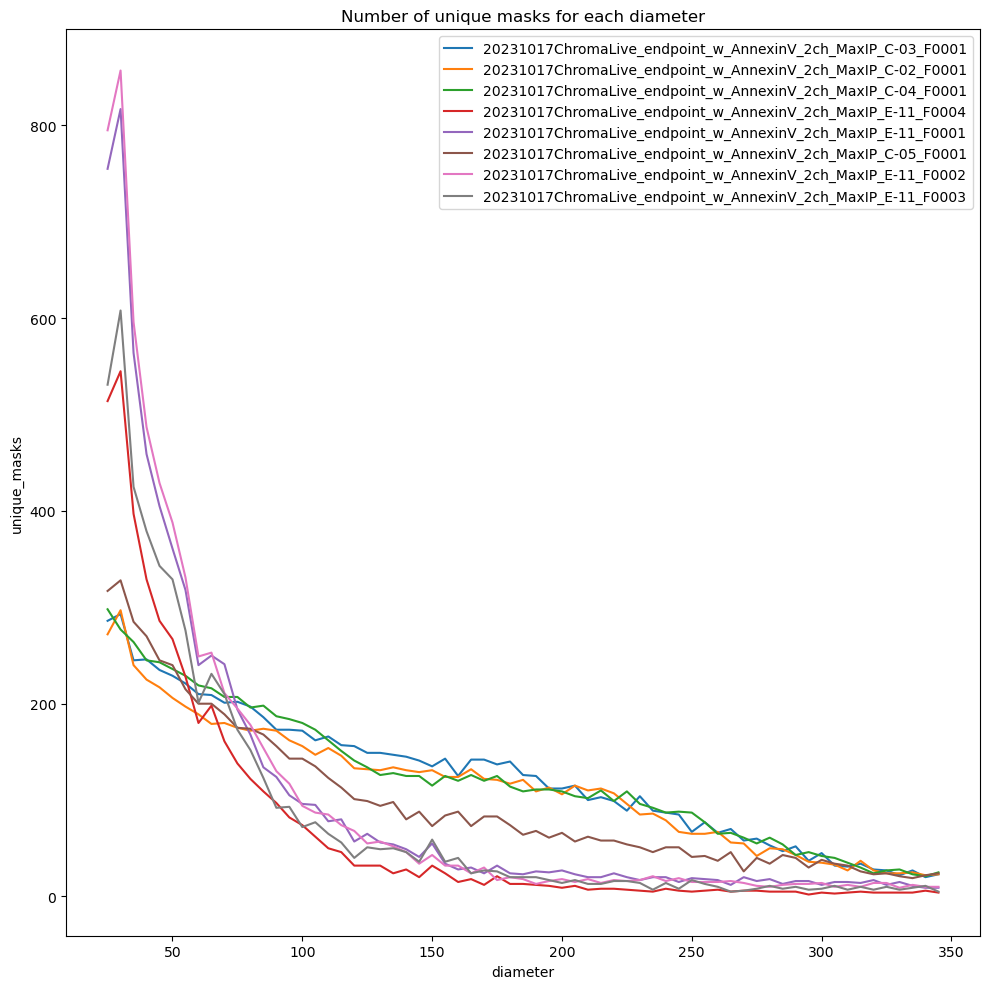

In [6]:
all_masks_df = pd.DataFrame(unique_masks_dict)
all_masks_df.head()

# plot the nuumber of masks for each diameter
plt.figure(figsize=(10, 10))
# plt.lineplot(data=all_masks_df, x="diameter", y="unique_masks", hue="image_dir")
sns.lineplot(data=all_masks_df, x="diameter", y="unique_masks", hue="image_dir")
# remove the legend
plt.legend(loc="upper right", fontsize=10)
plt.title("Number of unique masks for each diameter")
plt.tight_layout()
plt.savefig(
    figures_dir / f"unique_masks_vs_diameter_{str(input_dir).split('/')[-1]}.png"
)
plt.show()